## Семинар 8: "Снижение размерности"

ФИО: Притугин Михаил Алексеевич

In [21]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [22]:
X = fetch_olivetti_faces()['data']

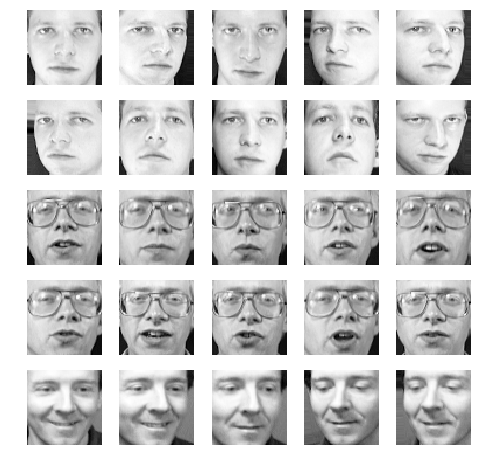

In [23]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [24]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

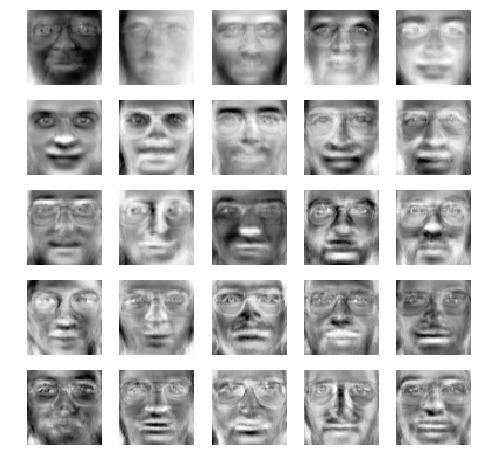

In [25]:
pca = PCA(n_components=25)

pca.fit(X)

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(pca.components_[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.explained\_variance\_ratio\_</b> и <b>np.cumsum()</b>

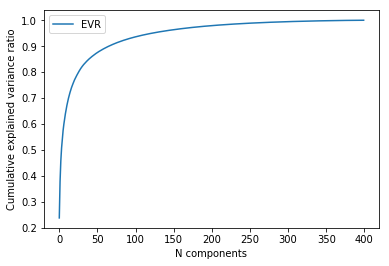

In [61]:
pca = PCA()

pca.fit(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_), label='EVR')
plt.xlabel('N components')
plt.ylabel('Cumulative explained variance ratio')
plt.legend()

In [54]:
model = PCA(n_components=122)
model.fit(X)
embedding = model.transform(X)
reconstruction = model.inverse_transform(embedding)

Text(0.5, 1.0, 'Error')

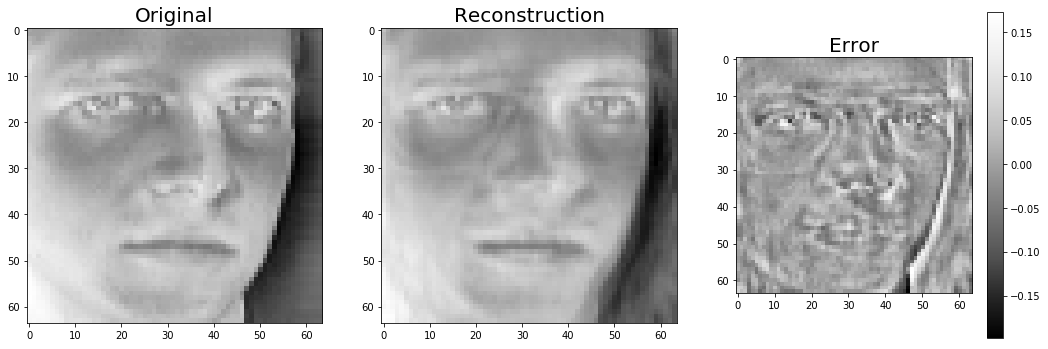

In [55]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow((X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Original', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow((reconstruction)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Reconstruction', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow((reconstruction - X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.title('Error', fontsize=20)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

50-60 где-то

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [56]:
# Код для отображения изображений в 2D
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

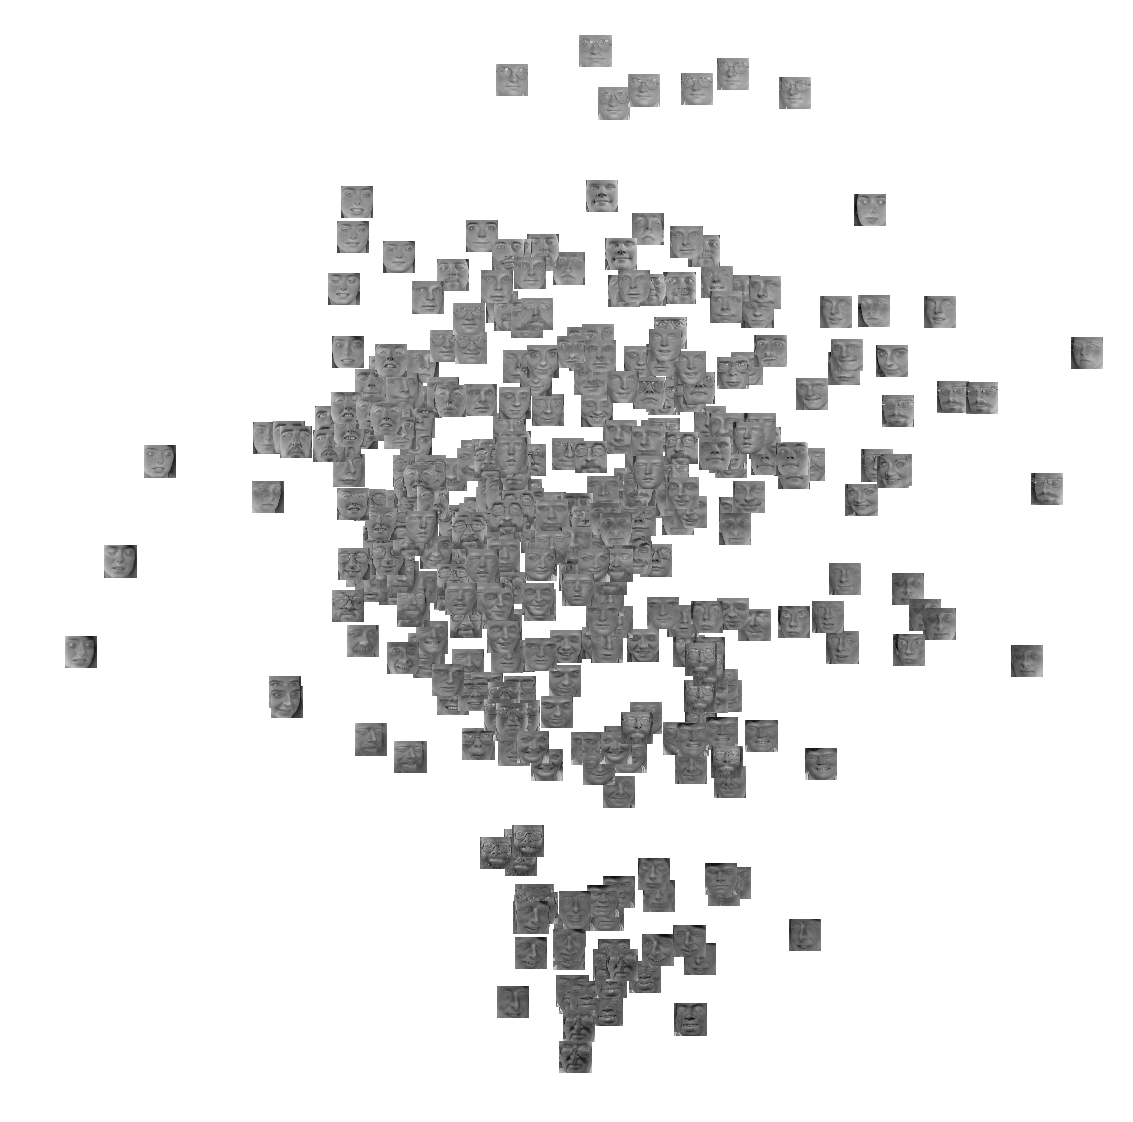

In [57]:
pca = PCA(n_components=2)

plot_dataset(X, pca.fit_transform(X))

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [29]:
class Net(torch.nn.Module):
    def __init__(self, emb_size=10):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(4096, 200),
                                     nn.BatchNorm1d(200),
                                     nn.Sigmoid(),
                                     nn.Linear(200, emb_size),
                                     nn.BatchNorm1d(emb_size),
                                     nn.Sigmoid())
        self.decoder = nn.Sequential(nn.Linear(emb_size, 200),
                                     nn.BatchNorm1d(200),
                                     nn.Sigmoid(),
                                     nn.Linear(200, 4096))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [31]:
data = Variable(torch.from_numpy(X), requires_grad=False).cpu()
data -= data.mean(0, keepdim=True)

In [41]:
model = Net(emb_size=10).cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, epochs):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            evr = 1 - (((output-data)**2).sum(1) / ((data)**2).sum(1)).mean().data.item()
            print('Эпоха: {}\tКачество восстановления: {:.2f}%'.format(
                epoch, evr*100))

        
train(model, 7000)

Эпоха: 0	Качество восстановления: -532.04%
Эпоха: 500	Качество восстановления: 61.97%
Эпоха: 1000	Качество восстановления: 64.39%
Эпоха: 1500	Качество восстановления: 69.52%
Эпоха: 2000	Качество восстановления: 74.67%
Эпоха: 2500	Качество восстановления: 79.35%
Эпоха: 3000	Качество восстановления: 82.84%
Эпоха: 3500	Качество восстановления: 85.30%
Эпоха: 4000	Качество восстановления: 87.07%
Эпоха: 4500	Качество восстановления: 88.53%
Эпоха: 5000	Качество восстановления: 89.60%
Эпоха: 5500	Качество восстановления: 90.32%
Эпоха: 6000	Качество восстановления: 91.11%
Эпоха: 6500	Качество восстановления: 91.56%


<i> 2.2 Какое качество восстановления удалось получить?</i>

После 7 эпох получилось получить 92% восстановления

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [48]:
def scan_evr(emb_sizes):
    emb_sizes = np.rint(emb_sizes).astype('int')
    print('Testing embeddings of sizes: {}'.format(emb_sizes))
    evrs = np.zeros(shape=emb_sizes.shape)
    for i, emb_size in enumerate(emb_sizes):
        print('Testing embedding of size: {}'.format(emb_size))
        model = Net(emb_size=int(emb_size)).cpu()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        model.train()
        for epoch in range(0, 1000):
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            if epoch % 500 == 0:
                err2 = ((output-data)**2).sum(1).mean()
                evr = 1 - err2 / (data**2).sum(1).mean()
                evr = evr.data.cpu().item()
                if evr > evrs[i]:
                    evrs[i] = evr
    return evrs

In [49]:
evrs = scan_evr(np.round(np.logspace(1, np.log10(200), 5), -1))

Testing embeddings of sizes: [ 10  20  40  90 200]
Testing embedding of size: 10
Testing embedding of size: 20
Testing embedding of size: 40
Testing embedding of size: 90
Testing embedding of size: 200


<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

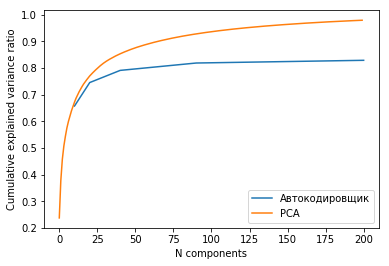

In [60]:
pca = PCA()

pca.fit(X)

plt.plot(np.round(np.logspace(1, np.log10(200), 5), -1), evrs, label='Автокодировщик')
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:200], label='PCA')
plt.xlabel('N components')
plt.ylabel('Cumulative explained variance ratio')
plt.legend()

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [52]:
model = Net(emb_size=2).cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()
for epoch in range(0, 10000):
    optimizer.zero_grad()
    output = model(data)
    loss = torch.nn.functional.mse_loss(output, data)
    loss.backward()
    optimizer.step()

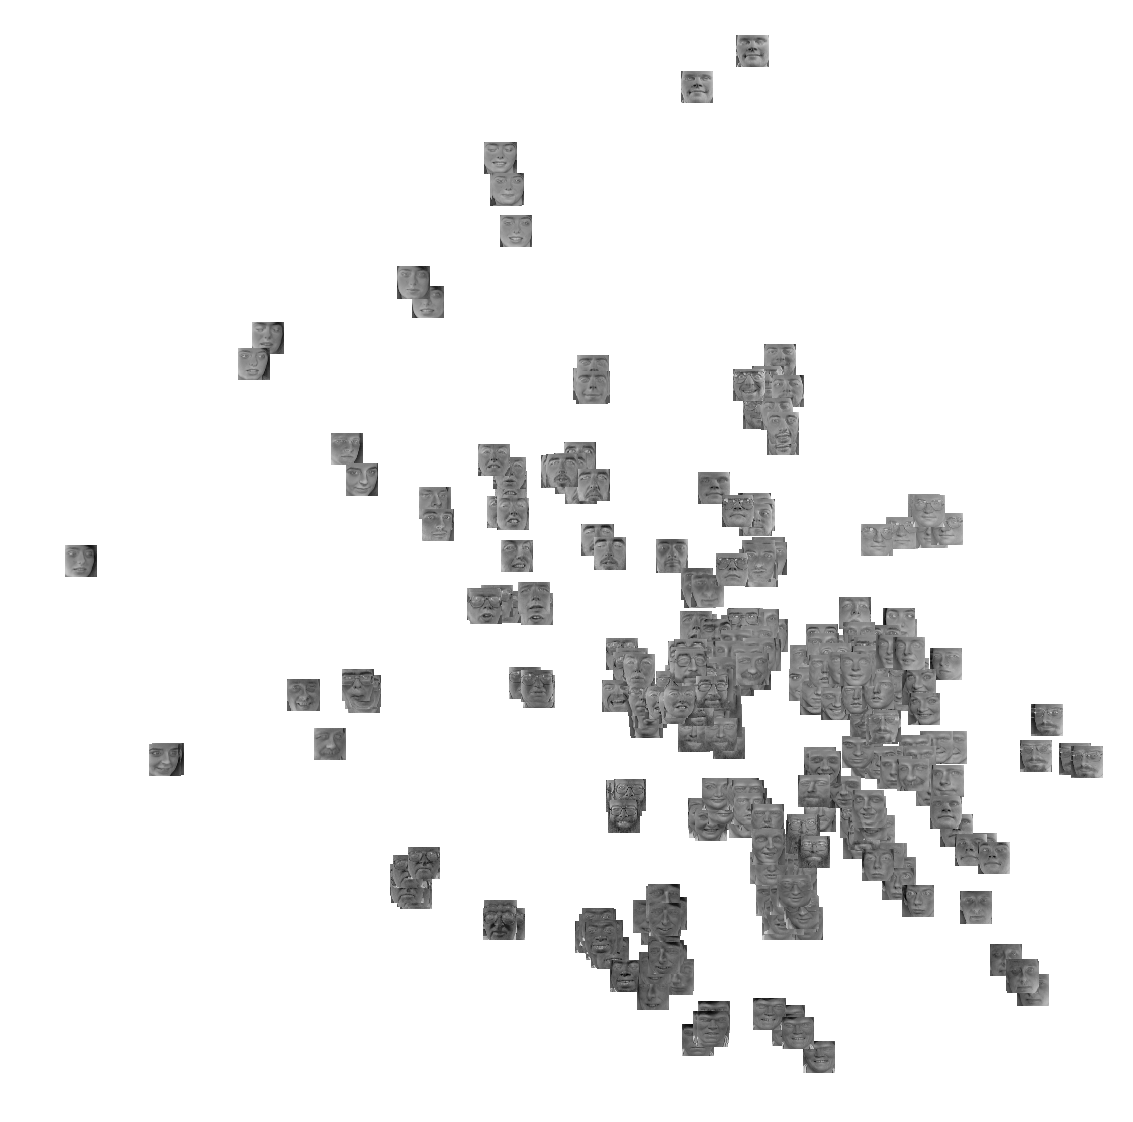

In [53]:
output = model.encoder(data).data.cpu().numpy()

plot_dataset(X, output)

Разные кластера - разные или сильно похожие люди

#### Feedback (опционально)


Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: